# Tutorial on how to use Brain_Data() Class
### Written by Luke Chang
<p>Brain_Data() is a python class in the nltools codebase that provides a representation of imaging data that is amenable to easily running statistical models.  It is based on the fmri_data() class in Matlab developed by Tor Wager distributed in the <a href=https://github.com/canlab/CanlabCore>canlabcore repository</a>.  The class relies heavily on <a href = http://nilearn.github.io>nilearn</a>. The basic idea of the class is to represent 3D or 4D data in vector form so that statistical operations can be run more efficiently.  3D data becomes 1D and 4D data becomes 2D.
</p>


## Initialize Python Modules
<p>Make sure you change the path of the output_dir to where you would like to run this tutorial.</p>

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import os
import sys
import time
from nltools.simulator import Simulator
from nltools.utils import get_resource_path,get_anatomical
from nltools.analysis import Predict, Roc
from nltools.data import Brain_Data,threshold
from nltools.mask import create_sphere
from nilearn.plotting.img_plotting import plot_epi, plot_roi
import matplotlib.pyplot as plt

from copy import deepcopy

output_dir = '/Users/lukechang/Downloads/Test_Brain_Data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create some fake data
<p>For this tutorial we will first create some fake data using nltools simulator() class.  This creates voxels in a sphere of radius <em>r</em> with a signal that is correlated with Y <em>cor</em> and with each other <em>cov</em>.  Gaussian noise of <em>sigma</em> is added to each voxel.  We are simulating <em>n_sub</em> subjects with <em>reps</em> observations each.</p>

In [19]:
tic = time.time() #Start Timer

sim = Simulator()
r = 10
sigma = .5
cor = .8
cov = .6
reps = 10
n_sub = 10
sim.create_cov_data(cor, cov, sigma, radius=r, reps = reps, n_sub = n_sub, output_dir = output_dir)
print 'Simulation: Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


Simulation: Elapsed: 30.73 seconds


/usr/local/lib/python2.7/site-packages/nltools-0.2-py2.7.egg/nltools/simulator.py:257: RuntimeWarning: covariance is not positive-semidefinite.
  mv_sim = np.random.multivariate_normal(np.zeros([n_vox+1]),cov_matrix, size=reps)


## Load Data Brain_Data Class
<p>next we will load data the data we created as a Brain_Data() instance.  This requires specifying a nibabel instance, or a valid file name pointing to nifiti data.  You can optionally specify a list of files.  To run a prediction analysis you must specify training labels as 'Y'.  Here we will load the simulated Y data.</p>

In [20]:
tic = time.time() #Start Timer

y=pd.read_csv(os.path.join(output_dir,'y.csv'),header=None,index_col=None)
y=np.array(y)[0]
dat = Brain_Data(data=os.path.join(output_dir,'centered_sphere_cor0.8_cov0.6_sigma0.5.nii.gz'),Y=y)
dat.X = pd.DataFrame({'Intercept':np.ones(len(dat.Y)),'X1':dat.Y},index=None)

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

Elapsed: 6.16 seconds


## Common Brain_Data() Methods
<p>There are many methods for the Brain_Data() class that can help with basic manipulation of the data.  Many methods can be chained as they can output a Brain_Data() instance.</p>

Shape of dat:  (100, 238955)
Shape of mean of dat:  (238955,)
Shape of standard Deviation of dat:  (238955,)
Plot Standard Deviation of dat: 
Plot 5th image in dat: 
nltools.data.Brain_Data(data=(3, 238955), Y=(3,), X=(3, 2), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
nltools.data.Brain_Data(data=(0,), Y=(0,), X=(0,), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
nltools.data.Brain_Data(data=(238955,), Y=(), X=(2,), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
nltools.data.Brain_Data(data=(2, 238955), Y=(2, 1), X=(2, 2), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])


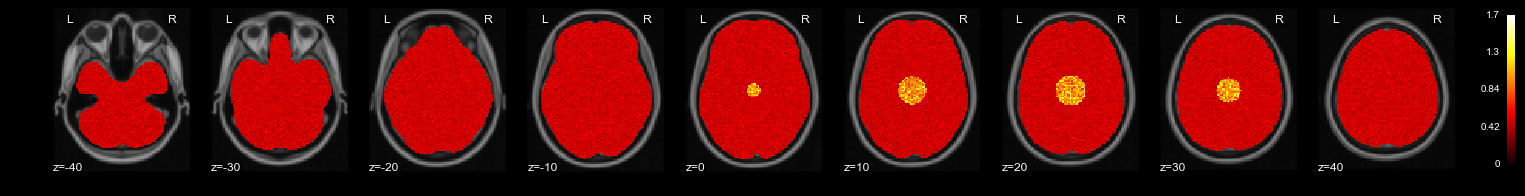

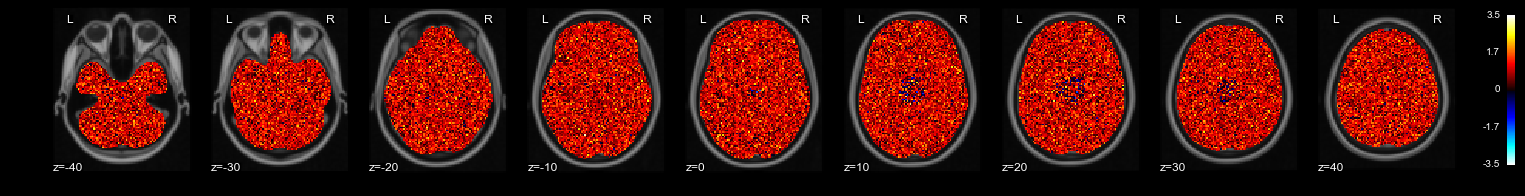

In [35]:
# Find the dimensions of the data.  images x voxels
print 'Shape of dat: ', dat.shape()

# Create a mean for every voxel over images
dat.mean()

# Show the dimensions of the mean image
print 'Shape of mean of dat: ', dat.mean().shape()

# Calculate the Standard deviation for each voxel across images
print 'Shape of standard Deviation of dat: ', dat.std().shape()

# We can create quick plots to inspect the data.
print 'Plot Standard Deviation of dat: '
dat.std().plot()

# We can convert the Brain_Data() instance into a nibabel instance.
d = dat.to_nifti()

# Brain_Data() instances can be sliced to select specific images
print 'Plot 5th image in dat: '
dat[4].plot()

# We can use any type of indexing to slice the data
print dat[[1,6,2]]

# We can empty an object
new = dat.empty()
print new

# We can also concatenate data using the append method
new = new.append(dat[4])
print new
new = new.append(dat[10])
print new

# Any Brain_Data object can be written out to a nifti file
dat.write(os.path.join(output_dir,'Tmp_Data.nii.gz'))

## Statistical Analyses
<p>There are several methods to conduct statistical analyses such as:
<ul>
<li>One sample t-tests</li>
<li>Univariate regression</li>
<li>Multivariate prediction</li>
</ul>
</p>
<p>The results of the statistical analyses are output as dictionaries, which can be indexed to find Brain_Data() instances containing each result (e.g., t, p images).  The results can be thresholded using the threshold() methods.</p>

Plot the results of a one sample t-test
Threshold the results using FDR with q<.05 and plot
Plot the beta parameters estimated using OLS for a univariate regression
Threshold the results using FDR with q<.05 and plot


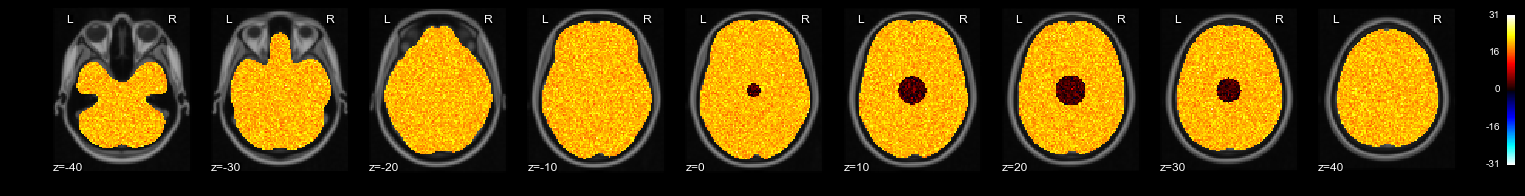

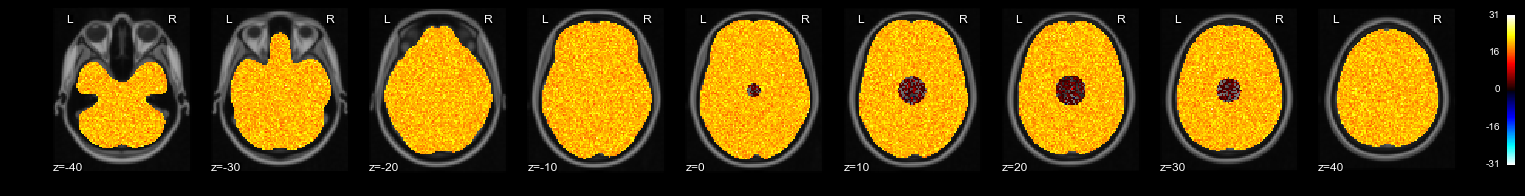

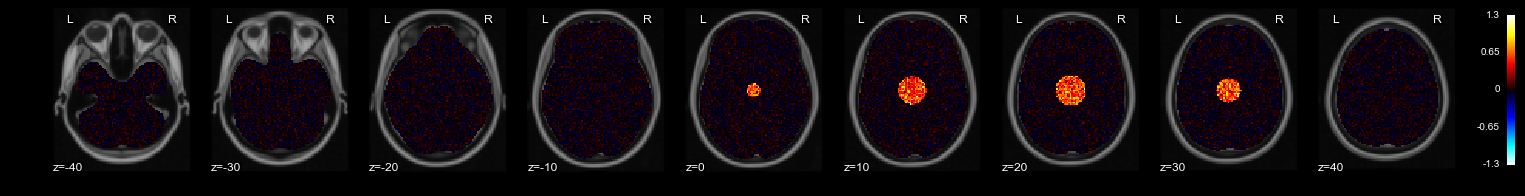

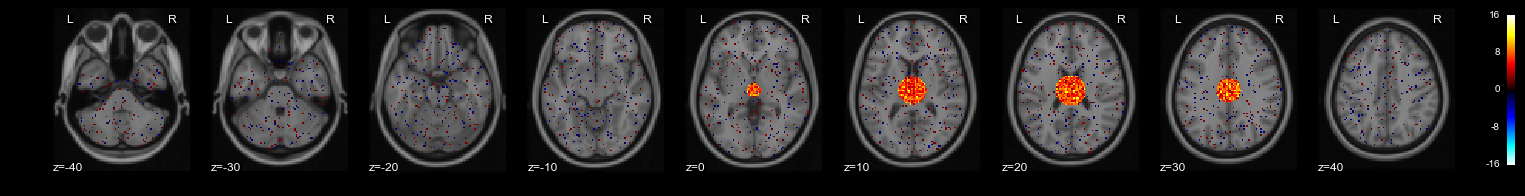

In [7]:
# Run a one-sample T-test
out = dat.ttest()
print 'Plot the results of a one sample t-test'
out['t'].plot()

# Threshold t-test results with FDR
print 'Threshold the results using FDR with q<.05 and plot'
tt = threshold(out['t'], out['p'], threshold_dict={'fdr':.05})
tt.plot()

# Run a univariate regression for a design matrix containing an intercept and one independent variable
# for one Subject.  
# X matrix must be a pandas instance
dat.X = pd.DataFrame({'Intercept':np.ones(len(dat.Y)),'X1':dat.Y},index=None)
out = dat.regress()
print 'Plot the beta parameters estimated using OLS for a univariate regression'
out['beta'][1].plot()

# Threshold t-test results with FDR
print 'Threshold the results using FDR with q<.05 and plot'
i=1
tt = threshold(out['t'][i], out['p'][i], threshold_dict={'fdr':.05})
tt.plot()


## Run a 2-stage multilevel regression akin to SPM
<p>Here we are going to run a separate regression for each subject and concatenate beta files and then run a one-sample t-test across subjects.
<br><br>
First, we initialize an empty Brain_Data instance and populate it with a loop that runs a separate regression for each participant.
<br><br>
Next, we run a second level t-test to determine which voxels are significantly different from zero and plot the t-test results and a thresholded t-image with 0.05 FDR correction.
</p>

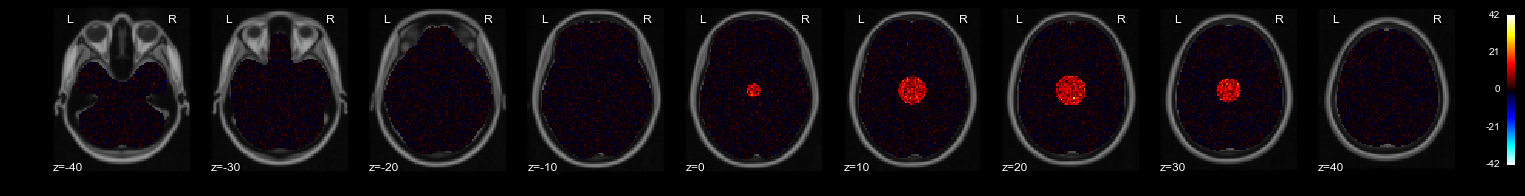

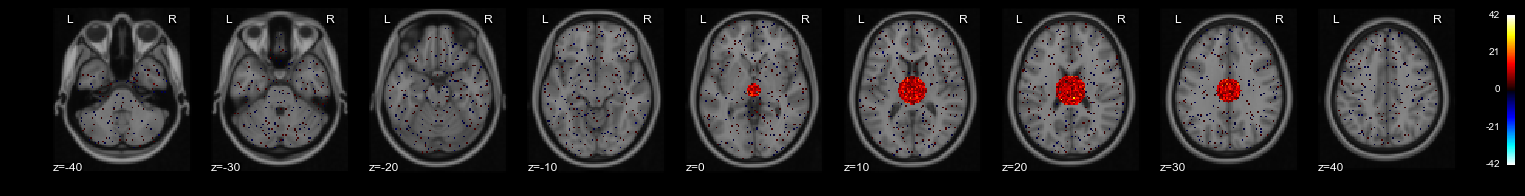

In [9]:
n_trials = 10
n_subs = 10

start = 0
stop = n_trials
dat.X = pd.DataFrame({'Intercept':np.ones(len(dat.Y)),'X1':dat.Y},index=None)
all = dat.empty()
for i in xrange(n_subs):
    sub_out = dat[start:stop].regress()
    start = start + n_trials
    stop = stop + n_trials
    tmp = sub_out['beta'].empty(data=False)[1]
    all = all.append(tmp)
    
l2 = all.ttest()
l2['t'].plot()
thr = threshold(l2['t'],l2['p'],threshold_dict={'fdr':.05})
thr.plot()

## Run Multivariate Prediction
<p>Running MVPA style analyses using multivariate regression is even easier and faster than univariate methods.  All you need to do is specify the algorithm and cross-validation parameters.
<br><br>
The output variable is a dictionary of the most useful output from the prediction analyses.  The predict function runs the prediction multiple times.  One of the iterations uses all of the data to calculate the 'weight_map'.  The other iterations are to estimate the cross-validated predictive accuracy.
</p>

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.56
overall CV Correlation: 0.85
['weight_map', 'rmse_all', 'yfit_xval', 'intercept_xval', 'r_all', 'weight_map_xval', 'intercept', 'r_xval', 'yfit_all', 'Y', 'cv', 'rmse_xval']
[ 0.18392472  1.33653326 -0.24337778  0.6372067   0.12071402  0.14600233
  0.46914663  1.34554646 -0.37771072  0.48026274  0.2188325   1.3216402
 -0.25095427  0.63116429  0.13647682  0.1147775   0.46091574  1.25370913
 -0.34941972  0.51580507  0.22924489  1.31369629 -0.24267204  0.66507577
  0.12676724  0.12025183  0.46074347  1.29228813 -0.34731064  0.48487394
  0.21298708  1.31938502 -0.24929271  0.65070868  0.08099495  0.13383417
  0.42460132  1.28613967 -0.39070112  0.5004271   0.21374334  1.32852482
 -0.24252022  0.64483327  0.08868953  0.09684412  0.40885592  1.3375904
 -0.37671804  0.45806429  0.23473352  1.31010458 -0.2000088   0.64274444
  0.11253741  0.14774234  0.41536047  1.30431985 -0.39239697  0.48

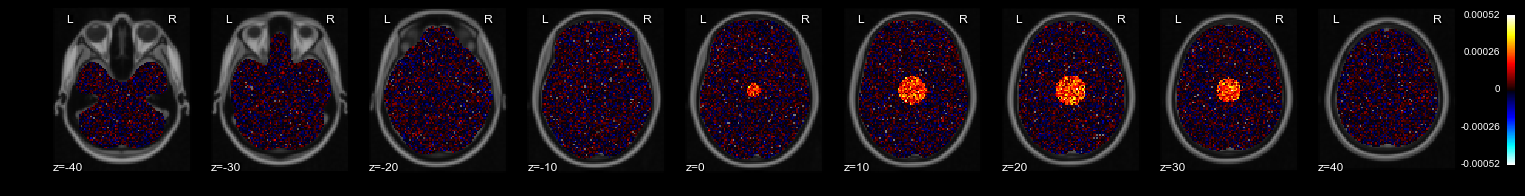

In [23]:
tic = time.time() #Start Timer

output = dat.predict(algorithm='ridge', cv_dict={'type': 'kfolds','n_folds': 5,'stratified':dat.Y}, plot=False)

# Display the available data in the output dictionary
print output.keys()

# Plot the multivariate weight map
output['weight_map'].plot()

# Return the cross-validated predicted data
print output['yfit_xval']

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

## Bootstrap Brain_Data Analysis Methods
<p>Sometimes we want to empirically estimate the standard error around an analysis using bootstrapping.  Here we can bootstrap the main statistical analyses implemented.  These are studentized bootstraps and time scales linearly.  Eventually, I'll parallelize this to speed it up dramatically.</p>

In [11]:
tic = time.time() #Start Timer

n_samples = 10

# Bootstrap Mean
out1 = dat.bootstrap(analysis_type='mean',n_samples=n_samples)
toc = time.time()
print 'Bootstrap Mean Time: %.2f seconds' % (toc - tic) #Stop timer

# Bootstrap Regress
tic2 = time.time() #Start Timer
out2 = dat.bootstrap(analysis_type='regress',n_samples=n_samples)
toc = time.time()
print 'Bootstrap Regress Time: %.2f seconds' % (toc - tic2) #Stop timer

# Bootstrap Predict
tic2 = time.time() #Start Timer
out3 = dat.bootstrap(analysis_type='predict',n_samples=n_samples, **{'algorithm':'ridge'} )
toc = time.time()
print 'Bootstrap Predict Time: %.2f seconds' % (toc - tic2) #Stop timer

print 'Total Time: %.2f seconds' % (time.time() - tic) #Stop timer

Bootstrap Mean Time: 4.98 seconds
Bootstrap Regress Time: 17.05 seconds
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
Bootstrap Predict Time: 7.71 seconds
Total Time: 29.74 seconds


## Apply Mask to Brain_Data Object
<p>Here we show how you can easily mask a Brain_Data instance using the apply_mask method.  First, we create a nibabel mask with a spherical ROI with a 10mm radius around a specific point in voxel space. We then create a new masked Brain_Data instance by applying this mask to the dat object.</p>

Total Time: 4.87 seconds


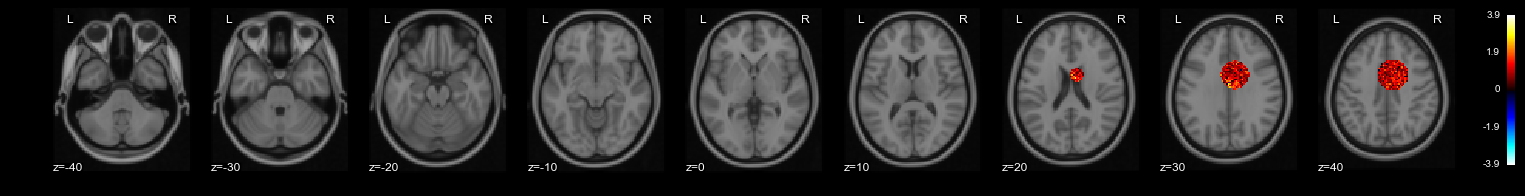

In [21]:
tic = time.time() #Start Timer

s1 = create_sphere([41, 64, 55], radius=10)
masked_dat = dat.apply_mask(s1)
masked_dat[1].plot()

print 'Total Time: %.2f seconds' % (time.time() - tic) #Stop timer

## Find Similarity between a Brain_Data object and another image
<p>Often we want to find the spatial similarity between two images.  This is easy to do with Brain_Data objects using the similarity method - simply pass in a single Brain_Data or Nibabel instance and it will return either a pearson correlation or dot-product scalar response. If the data object contains multiple images, it will return a vector of correlations.
<br><br>
This method can also automatically detect discrepancies in the mask size between the two objects.  We illustrate this by also calculating the similarity between the masked data object and a weight map calculated in the above examples.
</p>

Number of voxels going into the correlation:  238955
Mean Correlation: 0.04
Number of voxels going into the masked data correlation:  4169
Mean Correlation: 0.14
Total Time: 4.02 seconds


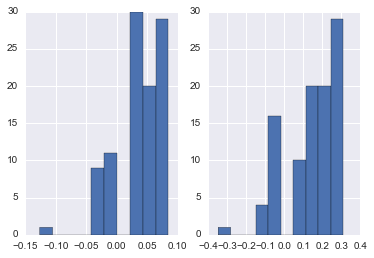

In [24]:
tic = time.time() #Start Timer

# Calculate spatial correlation between a bunch of images in the dat Brain_Data object 
# with a single weight_map from the multivariate prediction example
r = dat.similarity(output['weight_map'])
print "Number of voxels going into the correlation: ", dat.shape()[1]
print "Mean Correlation: %.2f" % (np.mean(r))
plt.subplot(1,2,1)
plt.hist(r)

# Now do the same thing with a masked object
r_masked = masked_dat.similarity(output['weight_map'])
print "Number of voxels going into the masked data correlation: ", masked_dat.shape()[1]
print "Mean Correlation: %.2f" % (np.mean(r_masked))
plt.subplot(1,2,2)
plt.hist(r_masked)

print 'Total Time: %.2f seconds' % (time.time() - tic) #Stop timer